# 03 - Classificando patologias em toras usando combinação de `LBP + SVM` e normalizando amostras pelo maior elemento do histograma

## Importando bibliotecas

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from zipfile import ZipFile
from skimage import io
from skimage.feature import local_binary_pattern

# Parâmetros do LBP
METHOD = 'nri_uniform'
RADIUS = 1
N_POINTS = 8

TARGET_NAMES = {'broca': 0,
                'fissura': 1,
                'musgo': 2,
                'quebra': 3}

## Processando imagens

In [4]:
path_dict = {name: [] for name in TARGET_NAMES}

with ZipFile('./patologias.zip') as zip_file:
  for path in zip_file.namelist():
    # a pasta de cada amostra é o segundo elemento do split
    folder = path.split('/')[1]
    # Separando amostras por classe
    if folder in TARGET_NAMES:
      path_dict[folder].append(f'./patologias.zip/{path}')


# Mostrando quantidade de amostras por classe
qtd_amostras_p_classe = []
for target in path_dict:
  n_amostras = len(path_dict[target])
  print(f'{target}: {n_amostras} amostras')

  qtd_amostras_p_classe.append(n_amostras)

N_MIN_DE_AMOSTRAS = min(qtd_amostras_p_classe)
amostra = []

for target_name in TARGET_NAMES:
  path_list = path_dict[target_name]
  path_list_slice = path_list[:N_MIN_DE_AMOSTRAS]
  
  for path in path_list_slice:
    img = io.imread(path, as_gray=True)
    
    lbp = local_binary_pattern(image=img, P=N_POINTS, R=RADIUS, method=METHOD).flatten()
    
    hist = pd.Series(lbp).value_counts().sort_index()
    arr = np.zeros(59)
    for i in hist.index:
      arr[int(i)] = hist[i]

    # Realizando normalização pelo maior elemento do histograma
    arr /= arr.max()

    df = pd.DataFrame(data=[arr])
    df['target'] = TARGET_NAMES[target_name]
    amostra.append(df)

data = pd.concat(amostra, ignore_index=True)
data.to_csv('./csvs/lbp_norm2_toras.csv')
data

broca: 298 amostras
fissura: 2766 amostras
musgo: 505 amostras
quebra: 679 amostras


,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,target
0,0.466817,0.409502,0.006033,0.052036,0.020362,0.376320,0.017345,0.052036,0.016591,0.079940,...,0.042986,0.024887,0.328808,0.017345,0.039216,0.023379,0.343891,0.568627,1.0,0
1,0.470242,0.383911,0.012099,0.041530,0.009810,0.385219,0.009810,0.054611,0.016351,0.077175,...,0.050033,0.022237,0.357750,0.020275,0.038914,0.020275,0.340419,0.563113,1.0,0
2,0.464980,0.323799,0.012101,0.068574,0.018702,0.326366,0.012101,0.051705,0.014668,0.090209,...,0.064906,0.028603,0.261459,0.026769,0.054639,0.035937,0.256326,0.559223,1.0,0
3,0.412659,0.281002,0.009539,0.076411,0.008545,0.274841,0.009837,0.082273,0.008843,0.052266,...,0.046900,0.036169,0.230624,0.035672,0.042826,0.034181,0.231419,0.602246,1.0,0
4,0.507357,0.284488,0.015635,0.077866,0.022685,0.277744,0.018087,0.087983,0.021459,0.080932,...,0.084304,0.028204,0.232986,0.020846,0.074801,0.025445,0.266401,0.551809,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1187,0.519384,0.302166,0.015964,0.039339,0.019384,0.285633,0.021665,0.030787,0.017674,0.048461,...,0.037058,0.021095,0.215507,0.016534,0.045040,0.026226,0.230331,0.605473,1.0,3
1188,0.502041,0.252154,0.015420,0.052154,0.022222,0.279365,0.016327,0.043084,0.017234,0.044444,...,0.049433,0.028571,0.218594,0.026304,0.049433,0.028118,0.193651,0.626757,1.0,3
1189,0.498685,0.241017,0.014023,0.066608,0.012270,0.234005,0.025416,0.081507,0.021034,0.085013,...,0.099912,0.033304,0.189308,0.023663,0.062226,0.022787,0.164768,0.567923,1.0,3
1190,0.504921,0.264194,0.015897,0.033308,0.016654,0.292203,0.021953,0.041635,0.015897,0.046934,...,0.037850,0.022710,0.206662,0.015897,0.043149,0.020439,0.218774,0.591219,1.0,3


In [5]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score,
                             classification_report,
                             confusion_matrix,
                             f1_score,
                             plot_confusion_matrix)

## Realizando 30 rodadas de classificação

Rodada 0	-	Seed 5167
              precision    recall  f1-score   support

       broca       0.97      0.88      0.92       100
     fissura       0.86      0.96      0.91        83
       musgo       0.94      0.96      0.95        82
      quebra       0.97      0.94      0.95        93

    accuracy                           0.93       358
   macro avg       0.93      0.94      0.93       358
weighted avg       0.94      0.93      0.93       358



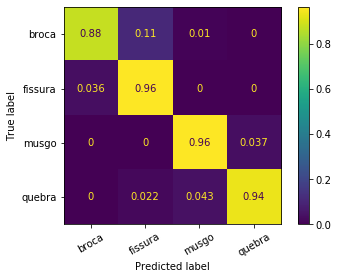

Rodada 1	-	Seed 5051
              precision    recall  f1-score   support

       broca       0.98      0.93      0.95        86
     fissura       0.92      0.97      0.94        87
       musgo       0.89      0.96      0.92        89
      quebra       0.96      0.89      0.92        96

    accuracy                           0.93       358
   macro avg       0.93      0.93      0.93       358
weighted avg       0.93      0.93      0.93       358



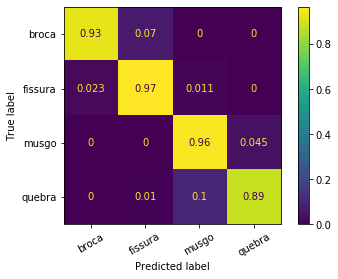

Rodada 2	-	Seed 3430
              precision    recall  f1-score   support

       broca       0.98      0.92      0.95        99
     fissura       0.89      0.98      0.93        81
       musgo       0.97      0.95      0.96        95
      quebra       0.96      0.96      0.96        83

    accuracy                           0.95       358
   macro avg       0.95      0.95      0.95       358
weighted avg       0.95      0.95      0.95       358



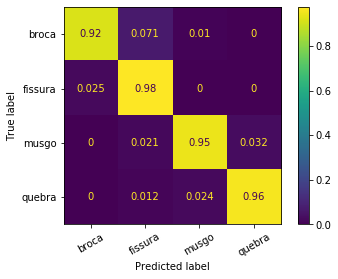

Rodada 3	-	Seed 2477
              precision    recall  f1-score   support

       broca       0.99      0.93      0.96        91
     fissura       0.88      0.97      0.92        88
       musgo       0.93      0.95      0.94        85
      quebra       0.98      0.91      0.95        94

    accuracy                           0.94       358
   macro avg       0.94      0.94      0.94       358
weighted avg       0.94      0.94      0.94       358



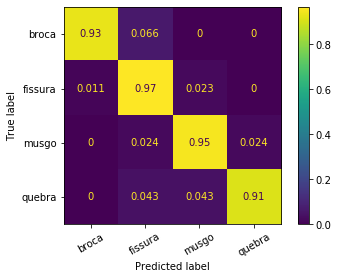

Rodada 4	-	Seed 6787
              precision    recall  f1-score   support

       broca       0.98      0.97      0.97        92
     fissura       0.96      0.96      0.96        78
       musgo       0.91      0.96      0.93        96
      quebra       0.95      0.91      0.93        92

    accuracy                           0.95       358
   macro avg       0.95      0.95      0.95       358
weighted avg       0.95      0.95      0.95       358



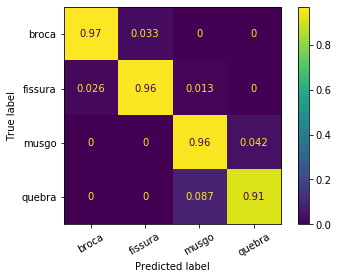

Rodada 5	-	Seed 821
              precision    recall  f1-score   support

       broca       0.96      0.92      0.94        88
     fissura       0.91      0.95      0.93        91
       musgo       0.93      0.97      0.95        90
      quebra       0.98      0.94      0.96        89

    accuracy                           0.94       358
   macro avg       0.95      0.94      0.94       358
weighted avg       0.95      0.94      0.94       358



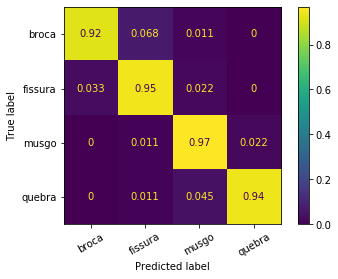

Rodada 6	-	Seed 1555
              precision    recall  f1-score   support

       broca       0.99      0.93      0.96        87
     fissura       0.93      0.99      0.96        93
       musgo       0.95      0.93      0.94        88
      quebra       0.96      0.97      0.96        90

    accuracy                           0.96       358
   macro avg       0.96      0.95      0.96       358
weighted avg       0.96      0.96      0.96       358



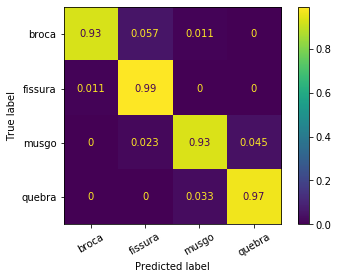

Rodada 7	-	Seed 7889
              precision    recall  f1-score   support

       broca       0.99      0.88      0.93        97
     fissura       0.85      0.97      0.90        86
       musgo       0.95      0.97      0.96        91
      quebra       0.98      0.94      0.96        84

    accuracy                           0.94       358
   macro avg       0.94      0.94      0.94       358
weighted avg       0.94      0.94      0.94       358



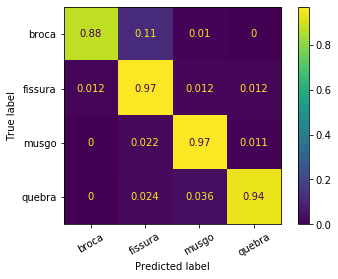

Rodada 8	-	Seed 30
              precision    recall  f1-score   support

       broca       0.96      0.90      0.93        86
     fissura       0.86      0.96      0.91        79
       musgo       0.96      0.94      0.95       105
      quebra       0.94      0.93      0.94        88

    accuracy                           0.93       358
   macro avg       0.93      0.93      0.93       358
weighted avg       0.94      0.93      0.93       358



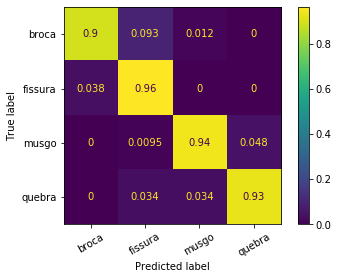

Rodada 9	-	Seed 1064
              precision    recall  f1-score   support

       broca       0.97      0.93      0.95        83
     fissura       0.90      0.96      0.93       100
       musgo       0.91      0.99      0.94        78
      quebra       1.00      0.90      0.95        97

    accuracy                           0.94       358
   macro avg       0.94      0.94      0.94       358
weighted avg       0.94      0.94      0.94       358



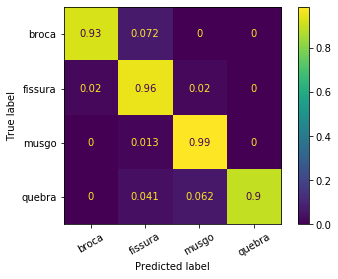

Rodada 10	-	Seed 1133
              precision    recall  f1-score   support

       broca       0.95      0.94      0.94        77
     fissura       0.96      0.95      0.95        91
       musgo       0.94      0.96      0.95        98
      quebra       0.95      0.95      0.95        92

    accuracy                           0.95       358
   macro avg       0.95      0.95      0.95       358
weighted avg       0.95      0.95      0.95       358



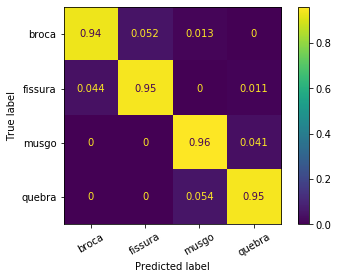

Rodada 11	-	Seed 7811
              precision    recall  f1-score   support

       broca       0.97      0.98      0.97        86
     fissura       0.97      0.96      0.96        89
       musgo       0.91      0.94      0.93        88
      quebra       0.93      0.91      0.92        95

    accuracy                           0.94       358
   macro avg       0.94      0.95      0.94       358
weighted avg       0.94      0.94      0.94       358



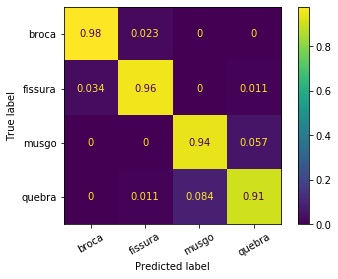

Rodada 12	-	Seed 3503
              precision    recall  f1-score   support

       broca       0.94      0.92      0.93        88
     fissura       0.92      0.92      0.92        87
       musgo       0.97      0.97      0.97        93
      quebra       0.96      0.98      0.97        90

    accuracy                           0.95       358
   macro avg       0.95      0.95      0.95       358
weighted avg       0.95      0.95      0.95       358



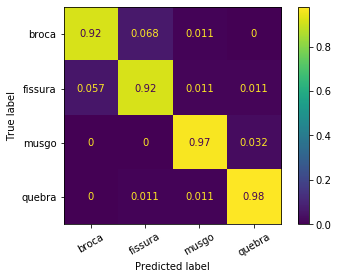

Rodada 13	-	Seed 1582
              precision    recall  f1-score   support

       broca       0.96      0.90      0.93        79
     fissura       0.91      0.92      0.91        87
       musgo       0.94      0.94      0.94       100
      quebra       0.90      0.93      0.91        92

    accuracy                           0.92       358
   macro avg       0.93      0.92      0.92       358
weighted avg       0.93      0.92      0.92       358



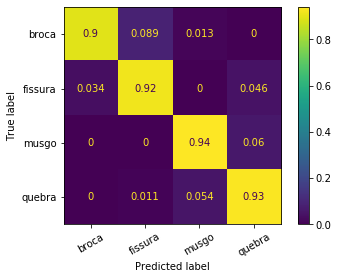

Rodada 14	-	Seed 3897
              precision    recall  f1-score   support

       broca       0.99      0.90      0.94        80
     fissura       0.92      0.96      0.94        83
       musgo       0.96      0.95      0.95        94
      quebra       0.93      0.97      0.95       101

    accuracy                           0.95       358
   macro avg       0.95      0.95      0.95       358
weighted avg       0.95      0.95      0.95       358



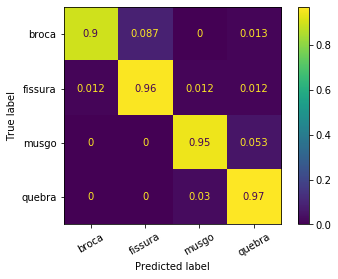

Rodada 15	-	Seed 4454
              precision    recall  f1-score   support

       broca       0.99      0.94      0.97       106
     fissura       0.89      0.99      0.93        79
       musgo       0.91      0.92      0.92        76
      quebra       0.97      0.92      0.94        97

    accuracy                           0.94       358
   macro avg       0.94      0.94      0.94       358
weighted avg       0.94      0.94      0.94       358



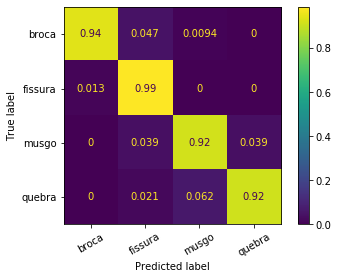

Rodada 16	-	Seed 2936
              precision    recall  f1-score   support

       broca       0.95      0.91      0.93        80
     fissura       0.93      0.94      0.94       100
       musgo       0.93      0.99      0.96        86
      quebra       0.98      0.95      0.96        92

    accuracy                           0.95       358
   macro avg       0.95      0.95      0.95       358
weighted avg       0.95      0.95      0.95       358



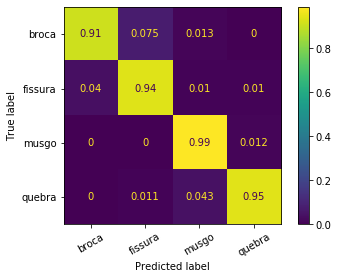

Rodada 17	-	Seed 4808
              precision    recall  f1-score   support

       broca       0.89      0.90      0.89        79
     fissura       0.90      0.91      0.90        97
       musgo       0.95      0.95      0.95        92
      quebra       0.97      0.94      0.96        90

    accuracy                           0.92       358
   macro avg       0.92      0.92      0.92       358
weighted avg       0.92      0.92      0.92       358



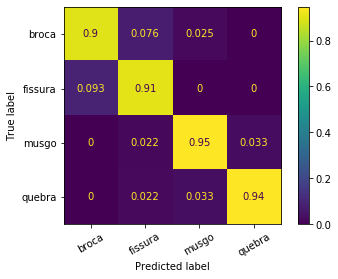

Rodada 18	-	Seed 7781
              precision    recall  f1-score   support

       broca       0.99      0.94      0.97        88
     fissura       0.94      0.96      0.95        83
       musgo       0.92      0.96      0.94       100
      quebra       0.95      0.93      0.94        87

    accuracy                           0.95       358
   macro avg       0.95      0.95      0.95       358
weighted avg       0.95      0.95      0.95       358



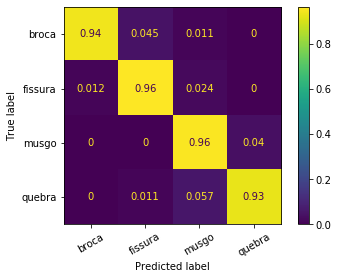

Rodada 19	-	Seed 7293
              precision    recall  f1-score   support

       broca       0.99      0.92      0.95        87
     fissura       0.90      0.97      0.93        79
       musgo       0.93      0.92      0.93        90
      quebra       0.94      0.94      0.94       102

    accuracy                           0.94       358
   macro avg       0.94      0.94      0.94       358
weighted avg       0.94      0.94      0.94       358



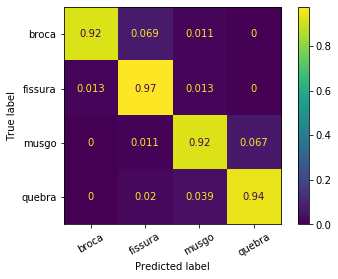

Rodada 20	-	Seed 4039
              precision    recall  f1-score   support

       broca       0.97      0.95      0.96        82
     fissura       0.94      0.98      0.96        87
       musgo       0.95      0.94      0.94        98
      quebra       0.96      0.96      0.96        91

    accuracy                           0.96       358
   macro avg       0.96      0.96      0.96       358
weighted avg       0.96      0.96      0.96       358



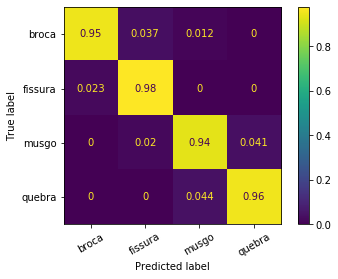

Rodada 21	-	Seed 1229
              precision    recall  f1-score   support

       broca       0.97      0.85      0.91        91
     fissura       0.83      0.98      0.90        82
       musgo       0.96      0.93      0.95        92
      quebra       0.96      0.96      0.96        93

    accuracy                           0.93       358
   macro avg       0.93      0.93      0.93       358
weighted avg       0.93      0.93      0.93       358



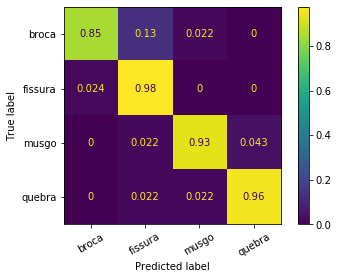

Rodada 22	-	Seed 6909
              precision    recall  f1-score   support

       broca       1.00      0.93      0.96        98
     fissura       0.90      0.99      0.94        82
       musgo       0.93      0.97      0.95        94
      quebra       0.97      0.92      0.94        84

    accuracy                           0.95       358
   macro avg       0.95      0.95      0.95       358
weighted avg       0.95      0.95      0.95       358



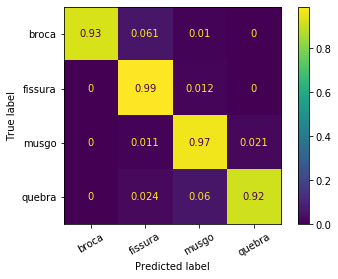

Rodada 23	-	Seed 7765
              precision    recall  f1-score   support

       broca       0.93      0.90      0.91        82
     fissura       0.91      0.90      0.91       104
       musgo       0.94      0.92      0.93        85
      quebra       0.91      0.97      0.94        87

    accuracy                           0.92       358
   macro avg       0.92      0.92      0.92       358
weighted avg       0.92      0.92      0.92       358



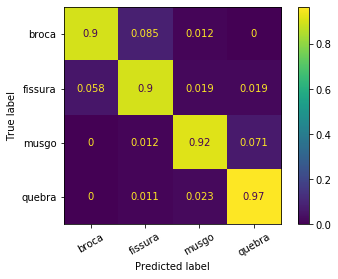

Rodada 24	-	Seed 1556
              precision    recall  f1-score   support

       broca       0.97      0.90      0.94        84
     fissura       0.86      0.97      0.92        78
       musgo       0.96      0.95      0.95        95
      quebra       0.97      0.94      0.95       101

    accuracy                           0.94       358
   macro avg       0.94      0.94      0.94       358
weighted avg       0.94      0.94      0.94       358



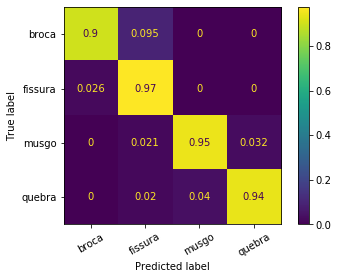

Rodada 25	-	Seed 4095
              precision    recall  f1-score   support

       broca       0.99      0.91      0.95        95
     fissura       0.89      0.99      0.94        74
       musgo       0.94      0.96      0.95        96
      quebra       0.96      0.94      0.95        93

    accuracy                           0.94       358
   macro avg       0.94      0.95      0.94       358
weighted avg       0.95      0.94      0.94       358



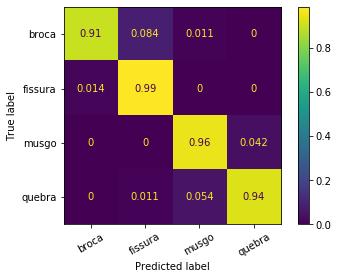

Rodada 26	-	Seed 3894
              precision    recall  f1-score   support

       broca       0.94      0.89      0.92        76
     fissura       0.89      0.95      0.92        93
       musgo       0.93      0.97      0.95       103
      quebra       0.99      0.92      0.95        86

    accuracy                           0.94       358
   macro avg       0.94      0.93      0.93       358
weighted avg       0.94      0.94      0.94       358



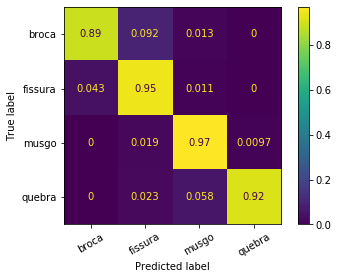

Rodada 27	-	Seed 6399
              precision    recall  f1-score   support

       broca       0.98      0.93      0.95        97
     fissura       0.91      0.94      0.93        90
       musgo       0.94      0.91      0.93        89
      quebra       0.89      0.94      0.91        82

    accuracy                           0.93       358
   macro avg       0.93      0.93      0.93       358
weighted avg       0.93      0.93      0.93       358



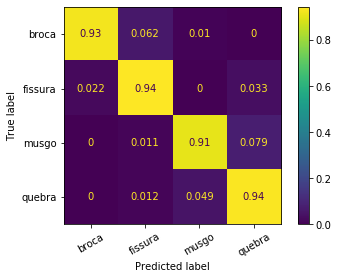

Rodada 28	-	Seed 7094
              precision    recall  f1-score   support

       broca       0.97      0.92      0.94        83
     fissura       0.92      0.97      0.95        80
       musgo       0.95      0.96      0.95        93
      quebra       0.96      0.95      0.96       102

    accuracy                           0.95       358
   macro avg       0.95      0.95      0.95       358
weighted avg       0.95      0.95      0.95       358



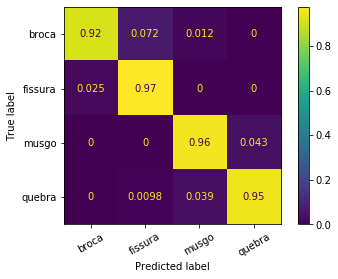

Rodada 29	-	Seed 6819
              precision    recall  f1-score   support

       broca       0.98      0.92      0.95        91
     fissura       0.92      0.94      0.93        87
       musgo       0.91      0.97      0.94        90
      quebra       0.95      0.92      0.94        90

    accuracy                           0.94       358
   macro avg       0.94      0.94      0.94       358
weighted avg       0.94      0.94      0.94       358



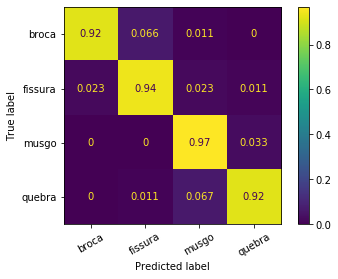

In [6]:
df = pd.read_csv('./csvs/lbp_norm2_toras.csv')
y = df.pop('target').values
X = df.values

# Gerando 30 sementes "aleatórias" dentro do intervalo [0, 8000)
seed_arr = np.random.randint(8000, size=30)

acc_e_f1_por_rodada = []
confu_matrices = []

for rodada, seed in enumerate(seed_arr):
  # separando dados
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

  clf = make_pipeline(StandardScaler(), SVC()).fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  
  # Adicionando resultados à respectiva lista
  acc_e_f1_por_rodada.append(
    [accuracy_score(y_test, y_pred)]
    + list(f1_score(y_test, y_pred, average=None)))

  confu_matrices.append(
    confusion_matrix(y_test, y_pred, normalize='true'))

  print(f'Rodada {rodada}\t-\tSeed {seed}')
  print(
    classification_report(
      y_true=y_test,
      y_pred=y_pred,
      target_names=TARGET_NAMES))

  plot_confusion_matrix(
    estimator=clf,
    X=X_test,
    y_true=y_test,
    display_labels=TARGET_NAMES,
    xticks_rotation=30,
    normalize='true')
  
  plt.show()

## Métricas do experimento

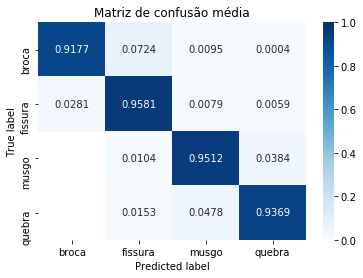

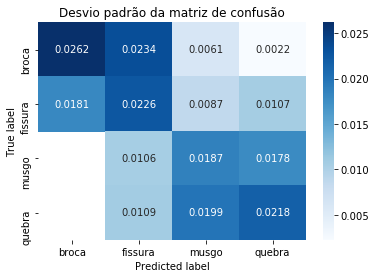

In [7]:
confusion_matrix_mean = np.mean(confu_matrices, axis=0)
confusion_matrix_std = np.std(confu_matrices, axis=0)

sns.heatmap(
    data=confusion_matrix_mean,
    cmap='Blues',
    vmin=0,
    vmax=1,
    annot=True,
    fmt='.4f',
    mask=confusion_matrix_mean == 0,
    xticklabels=TARGET_NAMES,
    yticklabels=TARGET_NAMES
    ).set(
        title='Matriz de confusão média',
        xlabel='Predicted label',
        ylabel='True label')

plt.show()

sns.heatmap(
    data=confusion_matrix_std,
    cmap='Blues',
    annot=True,
    fmt='.4f',
    mask=confusion_matrix_std == 0,
    xticklabels=TARGET_NAMES,
    yticklabels=TARGET_NAMES
    ).set(
        title='Desvio padrão da matriz de confusão',
        xlabel='Predicted label',
        ylabel='True label')

None

        Acurácia   f1-broca  f1-fissura   f1-musgo  f1-quebra
count  30.000000  30.000000   30.000000  30.000000  30.000000
mean    0.940689   0.942506    0.930602   0.943435   0.945569
std     0.009153   0.019651    0.018582   0.012345   0.014544
min     0.921788   0.893082    0.898876   0.915033   0.911243
25%     0.933659   0.929205    0.915914   0.936613   0.939205
50%     0.941341   0.944577    0.930774   0.945354   0.945652
75%     0.946927   0.957030    0.943330   0.951872   0.955949
max     0.955307   0.972678    0.961538   0.967742   0.967033


Acurácia,f1-broca,f1-fissura,f1-musgo,f1-quebra
0.932961,0.921466,0.909091,0.951807,0.950820
0.932961,0.952381,0.943820,0.918919,0.918919
0.949721,0.947917,0.929412,0.957447,0.963855
0.941341,0.960452,0.918919,0.941860,0.945055
0.949721,0.972678,0.961538,0.934010,0.933333
0.944134,0.941860,0.929730,0.945652,0.960000
0.955307,0.958580,0.958333,0.942529,0.961326
0.935754,0.928962,0.902174,0.956522,0.957576
0.932961,0.927711,0.910180,0.951923,0.937143
0.941341,0.950617,0.927536,0.944785,0.945652


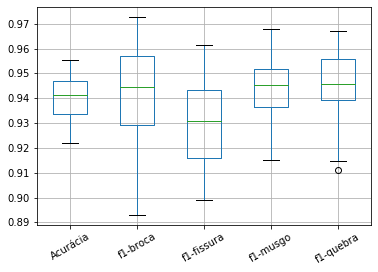

In [8]:
acc_df = pd.DataFrame(
  data=acc_e_f1_por_rodada,
  columns=['Acurácia'] + [f'f1-{name}' for name in TARGET_NAMES])

print(acc_df.describe())

acc_df.boxplot(rot=30)

acc_df.style.hide_index().background_gradient(cmap='Blues')